# 如何用Keras实现GAN

今天我们来讲一下使用Keras实现GAN的具体过程。

我们用MINST数据集来做这个测试。

首先我们导入需要的所有库

In [4]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.legacy.layers import MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from BatchNorm_GAN import BatchNormGAN
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import pickle, random, sys, keras
from keras.models import Model
from IPython import display

sys.path.append("../common")
from keras.utils import np_utils
from tqdm import tqdm

K.set_image_dim_ordering('th')

准备训练集

In [5]:
# 28 x 28 的图片
img_rows, img_cols = 28, 28

# 把数据集洗一洗
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 排好
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# 看看我们所有数据的个数和长相
print(np.min(X_train), np.max(X_train))
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 1.0
X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [6]:
# 做个指示器，告诉算法，现在这个net（要么是dis要么是gen），能不能被继续train
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [7]:
# 看一个每一个训练数据的长相
shp = X_train.shape[1:]
print(shp)

dropout_rate = 0.25

# 设置gen和dis的opt
# 大家可以尝试各种组合
opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
#opt = Adam(lr=1e-3)
#opt = Adamax(lr=1e-4)
#opt = Adam(lr=0.0002)
#opt = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
nch = 200

# 造个GEN
nch = 200
g_input = Input(shape=[100])
# 倒过来的CNN第一层（也就是普通CNN那个flatten那一层）
H = Dense(nch*14*14, init='glorot_normal')(g_input)
H = BatchNormGAN()(H)
H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)
# upscale上去2倍大。也就是从14x14 到 28x28
H = UpSampling2D(size=(2, 2))(H)
# CNN滤镜
H = Convolution2D(int(nch/2), 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormGAN()(H)
H = Activation('relu')(H)
# CNN滤镜
H = Convolution2D(int(nch/4), 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormGAN()(H)
H = Activation('relu')(H)
# 合成一个大图片
H = Convolution2D(1, 1, 1, border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


# 造个DIS
# 这就是一个正常的CNN
d_input = Input(shape=shp)
# 滤镜
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
# 滤镜
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
# flatten之后，接MLP
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
# 出一个结果，『是』或者『不是』
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

make_trainable(discriminator, False)
# 为stacked GAN做准备
# 然后合成一个GAN的构架
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)

GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()

(1, 28, 28)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 39200)             3959200   
_________________________________________________________________
batch_norm_gan_1 (BatchNormG (None, 39200)             156800    
_________________________________________________________________
activation_1 (Activation)    (None, 39200)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 14, 14)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 200, 28, 28)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 28, 28)       180100   

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(39200, kernel_initializer="glorot_normal")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (3, 3), kernel_initializer="glorot_uniform", padding="same")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (3, 3), kernel_initializer="glorot_uniform", padding="same")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), kernel_initializer="glorot_uniform", padding="same")`
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), activation="relu", padding="same", strides=(2, 2))`
/usr/local/lib/python3.5/dist-packa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 14, 14)       6656      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 14, 14)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 14, 14)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 512, 7, 7)         3277312   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512, 7, 7)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512, 7, 7)         0         
__________

接下来两个画图功能。

In [8]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

In [9]:

def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

提前训练DIS

让它学会区别对错

In [10]:
ntrain = 10000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=1, batch_size=32)
y_hat = discriminator.predict(X)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
20000/20000 [==============================] - 31s - loss: 0.0073    


简单判断一下DIS的训练效果：

In [11]:

y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))

Accuracy: 100.00 pct (20000 of 20000) right


In [12]:
# 设置一下存储D和G的格式
losses = {"d":[], "g":[]}

In [13]:
# 训练正经去了
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # 生成图片
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # 训练DIS
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        # 当然，要让DIS可以被训练
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # 训练 Generator-Discriminator stack
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        # 这个时候，让DIS不能被变化。保证判断结果一致性
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # 看看新图长什么样子
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()

玩玩看！

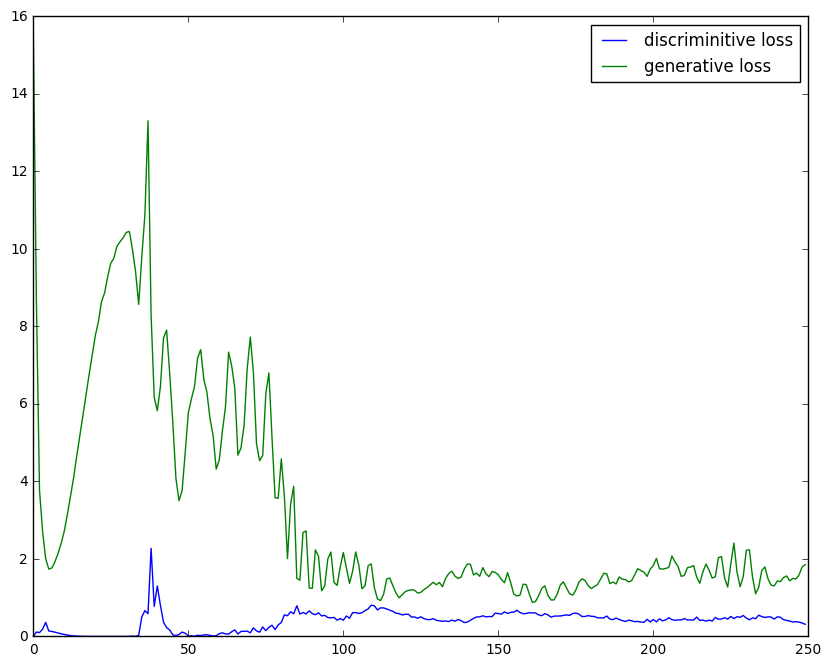

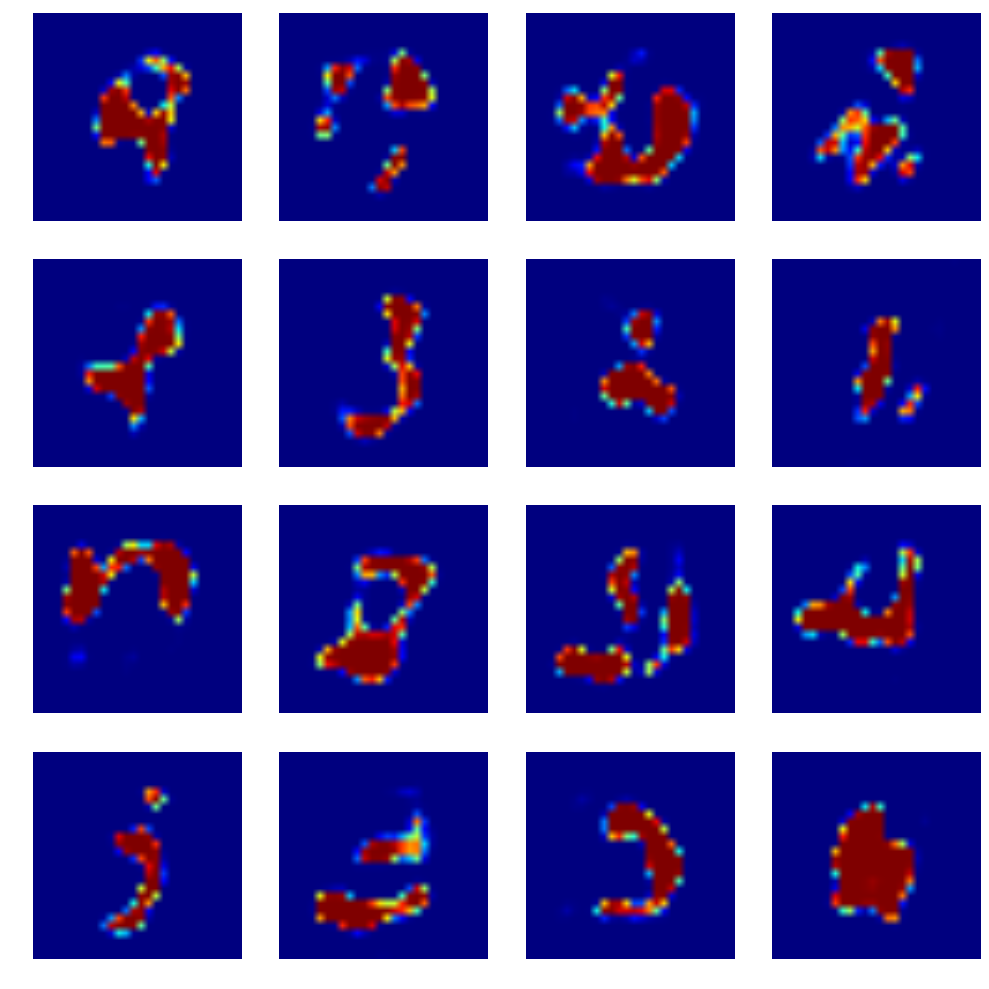

100%|██████████| 250/250 [03:03<00:00,  1.16s/it]


In [14]:
train_for_n(nb_epoch=250, plt_frq=25,BATCH_SIZE=128)

换个learning rate试试看

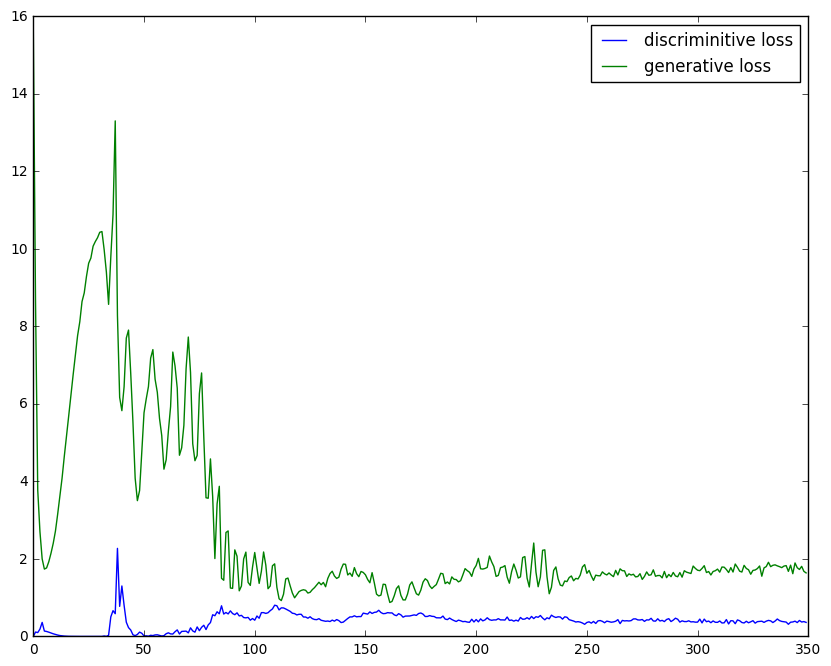

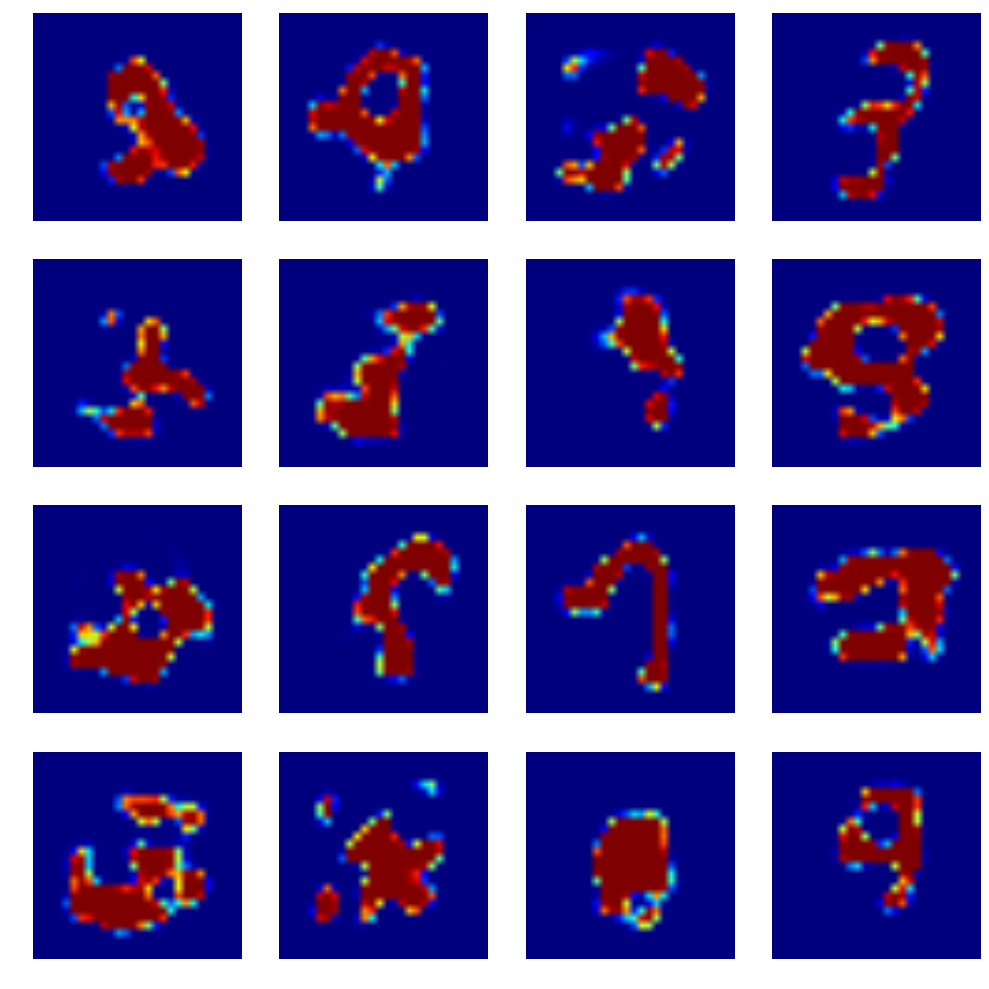

100%|██████████| 100/100 [01:23<00:00,  1.19s/it]


In [15]:
# 直接用K调用模型中 opt和dopt两个数值
K.set_value(opt.lr, 1e-4)
K.set_value(dopt.lr, 1e-5)
train_for_n(nb_epoch=100, plt_frq=10,BATCH_SIZE=128)

以上